## Define task

In this notebook, I will analyze trends in online shopping in Brazil between 2016 and 2018 using Olist (a Brazilian e-commerce website like Amazon). I will first start with performing an extensive EDA on the 8 datasets that I have in order to understand the initial variables at hand (growth in sales, most purchased products, cities with the most online purchases, etc.).

In the first part of the analysis, I will work on building a sentimental analysis model using NLP that predicts whether the customer is satisfied with their online purchase or not based on the reviews and scores they keep after completing the purchase and receiving the product.

In the second part, I will cluster the different users of the website into low, medium and high value users using the RFM metrics (recency, frequency and monetary) to predict which segment of clients yields the highest returns thus should be the priority clients.

#### Import core packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('Core packages have been successfully loaded.')

Core packages have been successfully loaded.


#### Ignore future warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Import datasets

In [3]:
customerData = pd.read_csv('/Users/Coding/Desktop/E-commerce/customers_dataset.csv')
geolocationData = pd.read_csv('/Users/Coding/Desktop/E-commerce/geolocation_dataset.csv')
ordersData = pd.read_csv('/Users/Coding/Desktop/E-commerce/orders_dataset.csv')
itemsData = pd.read_csv('/Users/Coding/Desktop/E-commerce/order_items_dataset.csv')
paymentData = pd.read_csv('/Users/Coding/Desktop/E-commerce/order_payments_dataset.csv')
reviewsData = pd.read_csv('/Users/Coding/Desktop/E-commerce/order_reviews_dataset.csv')
productsData = pd.read_csv('/Users/Coding/Desktop/E-commerce/products_dataset.csv')
sellersData = pd.read_csv('/Users/Coding/Desktop/E-commerce/sellers_dataset.csv')

print('All datasets are loaded and ready to be used.')

All datasets are loaded and ready to be used.


## Understand data

***
**1. I will create a table that displays the nb of rows, nb of columns, total nb of nulls per dataset, nb of columns that contain nulls and the names of the columns that contain null values for each of my 8 datasets.**
***

In [4]:
#Create a collection that contains all 8 datasets
datasets = [customerData, geolocationData, ordersData, itemsData, paymentData, reviewsData, productsData, sellersData]
names = ['customerData', 'geolocationData', 'ordersData', 'itemsData', 'paymentData','reviewsData',
         'productsData', 'sellersData']

#Create a dataframe with the previously specified information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['total_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

#Set the table style
data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,total_null_columns,null_columns
0,customerData,99441,5,0,0,
1,geolocationData,1000163,5,0,0,
2,ordersData,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,itemsData,112650,7,0,0,
4,paymentData,103886,5,0,0,
5,reviewsData,100000,8,204815,3,"review_comment_title, review_comment_message, review_english"
6,productsData,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellersData,3095,4,0,0,


***
**2. I will build a function that generates a table with more in-depth information about each dataset (feature names, data types, percent of null values per feature, nb of categorial variables, total null values per feature) in order to better understand the data that I will be working with.**
***

In [5]:
#Define function that will give the information of interest
def data_overview(df, corr = False, label_name = None, sort_by = 'amt_null',
                  thresh_percent_null = 0, thresh_corr_label = 0):

    #Create dataframe with information on null values
    df_null = pd.DataFrame(df.isnull().sum()).reset_index()
    df_null.columns = ['feature', 'amt_null']
    df_null['percent_null'] = df_null['amt_null'] / len(df)

    #Return the type and the number of categorical features in the dataset
    df_null['dtype'] = df_null['feature'].apply(lambda x: df[x].dtype)
    df_null['nb_cat'] = [len(df[col].value_counts()) if df[col].dtype == 'object' else 0 for col in
                          df_null['feature'].values]

    if corr:
        #Extract correlation information with the target feature
        label_corr = pd.DataFrame(df.corr()[label_name])
        label_corr = label_corr.reset_index()
        label_corr.columns = ['feature', 'target_pearson_corr']

        #Merge information gathered into one dataset
        df_null_overview = df_null.merge(label_corr, how = 'left', on = 'feature')
        df_null_overview.query('target_pearson_corr > @thresh_corr_label')
    else:
        df_null_overview = df_null

    #Filter null data according to set threshold
    df_null_overview.query('percent_null > @thresh_percent_null')

    #Sort the dataframe
    df_null_overview = df_null_overview.sort_values(by = sort_by, ascending = False)
    df_null_overview = df_null_overview.reset_index(drop = True)

    return df_null_overview

In [6]:
#Create empty set
df_overview = pd.DataFrame({})
name_col = []

#Collect required data and append into one final dataset
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))
    df_overview['dataset_name'] = name_col

#Generate overview dataset
df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'amt_null', 'percent_null', 'dtype', 'nb_cat']]
df_overview

,dataset_name,feature,amt_null,percent_null,dtype,nb_cat
0,customerData,customer_id,0,0.000000,object,99441
1,customerData,customer_unique_id,0,0.000000,object,96096
2,customerData,customer_zip_code_prefix,0,0.000000,int64,0
3,customerData,customer_city,0,0.000000,object,4119
4,customerData,customer_state,0,0.000000,object,27
0,geolocationData,geolocation_zip_code_prefix,0,0.000000,int64,0
1,geolocationData,geolocation_lat,0,0.000000,float64,0
2,geolocationData,geolocation_lng,0,0.000000,float64,0
3,geolocationData,geolocation_city,0,0.000000,object,8011
4,geolocationData,geolocation_state,0,0.000000,object,27


I will use this table when performing my EDA. This table helps me understand what type of data I am working with and what relationship can I build between different datasets.

## Exploratory Data Analysis (EDA)

### 1. Frequency of each order status

I will merge the ordersData and customerData datasets into one unique dataset in order to plot the frequencies of the order status. The relationship between the 2 datasets will be based on the 'customer ID' feature.

#### Define function for plotting volume of a single categorical variable (*will be used several times in the notebook*)

In [7]:
def single_countplot(df, ax, x = None, y = None, top = None, order = True, hue = False, palette = 'gist_earth',
                     width = 0.75, sub_width = 0.3, sub_size = 12):
    
    #Check plotting by breaking some categorical variables
    ncount = len(df)
    if x:
        col = x
    else:
        col = y

    #Plot top categorical variables
    if top is not None:
        cat_count = df[col].value_counts()
        top_categories = cat_count[:top].index
        df = df[df[col].isin(top_categories)]

    #Validate arguments and plotting graph
    if hue != False:
        if order:
            sns.countplot(x = x, y = y, data = df, palette = palette, ax = ax,
                          order = df[col].value_counts().index, hue = hue)
        else:
            sns.countplot(x = x, y = y, data = df, palette = palette, ax = ax, hue = hue)
    else:
        if order:
            sns.countplot(x = x, y = y, data = df, palette = palette, ax = ax, order = df[col].value_counts().index)
        else:
            sns.countplot(x = x, y = y, data = df, palette = palette, ax = ax)

    #Add percentage label
    if x:
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), ha = 'center', va = 'bottom')
    else:
        for p in ax.patches:
            x = p.get_bbox().get_points()[1, 0]
            y = p.get_bbox().get_points()[:, 1]
            ax.annotate('{} ({:.1f}%)'.format(int(x), 100. * x / ncount), (x, y.mean()), va = 'center')

#### Plot the volume (frequency) of each order status

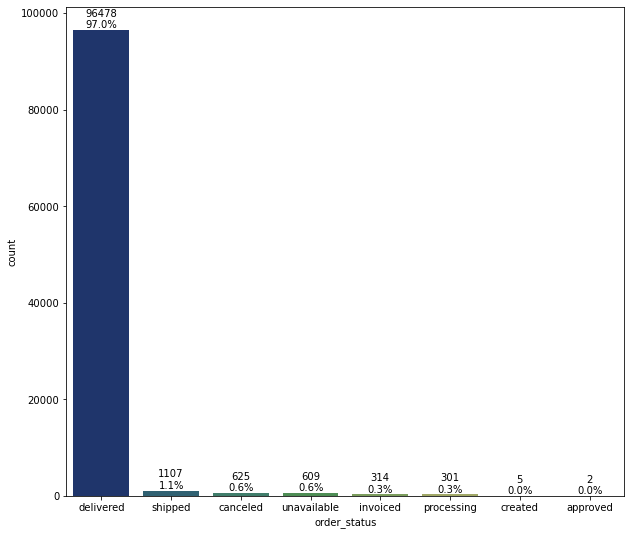

In [8]:
#Merge the ordersData and customerData datasets on customer_id
df_orders = ordersData.merge(customerData, how = 'left', on = 'customer_id')

#Initialize and generate plot
fig, ax = plt.subplots(figsize = (10, 9))
single_countplot(df_orders, x = 'order_status', ax = ax)
plt.show()

From the above countplot, it can be deduced that the majority of orders **(97%)** were already delivered to the final client. The remaining **3%** belongs to the other 7 status (shipped, canceled, unavailable, invoiced, processing, created and approved).

### 2. E-commerce trend in Brazil between 2016 and 2018

In this section, I will examine the online shopping trend in Brazil between 2016 and 2018. The aim is to see if there is an increasing or decreasing trend, or in other words, whether online shopping is gaining popularity or not in Brazil. In order to do so, I will extract valuable information on the purchases from the timestamp data from the ordersData dataset (year, month, day, hour, etc.).

#### Feature engineering on timestamp data (create new variables)

In [9]:
#Select timestamp features from ordersData dataset
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']

#Iterate through timestamp_cols and change type to datetime
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
#Extract attributes on purchase date - (year and month)
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

#Extract attributes on purchase date - (day and day of week)
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

#Extract attributes on purchase date - (hour and time of day)
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)

#Create hour bins and labels
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels = hours_labels)

#Display new dataframe after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


#### Plot e-commerce trend in Brazil

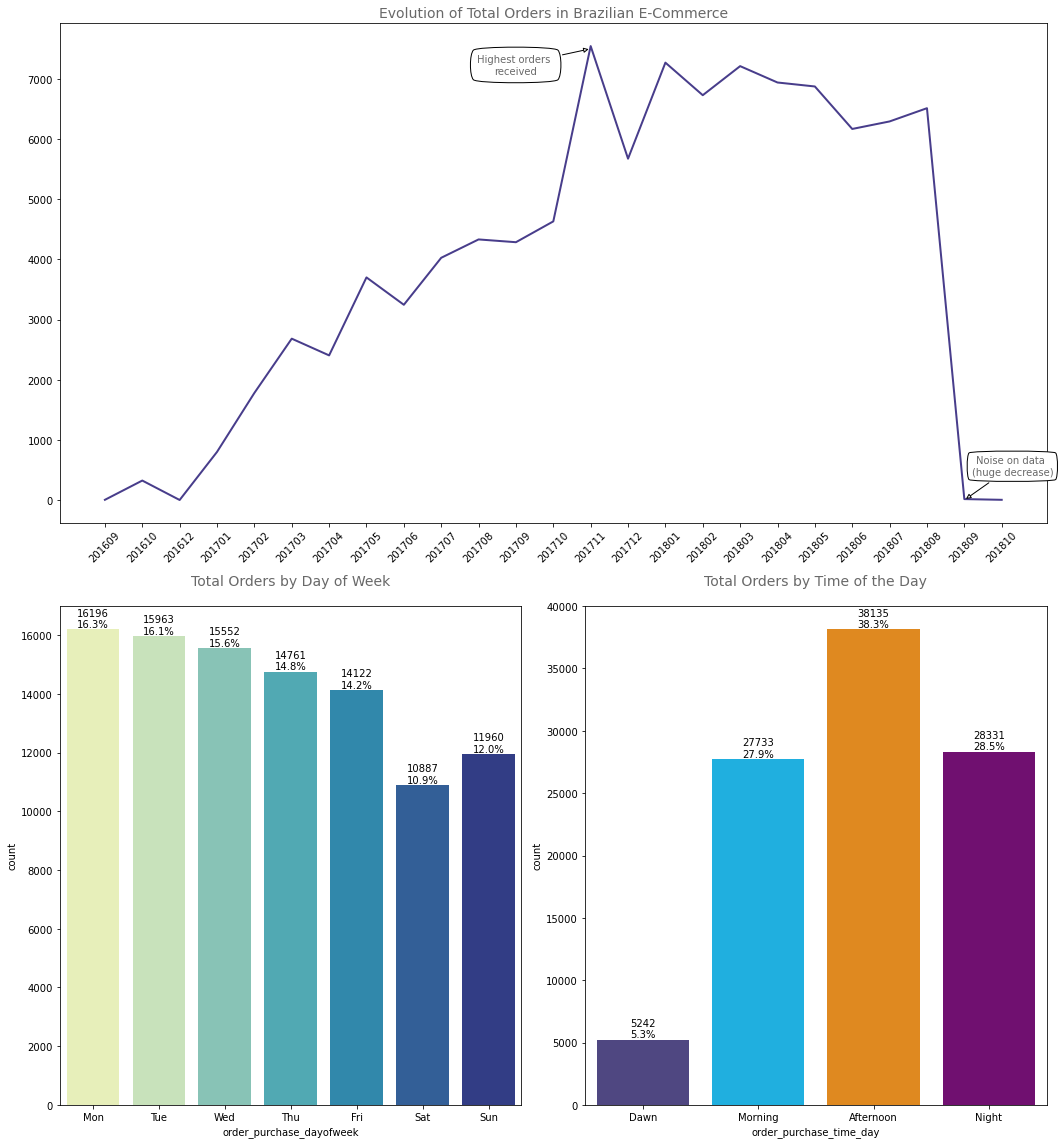

In [10]:
#Import package for plotting
from matplotlib.gridspec import GridSpec

#Initialize plot
fig = plt.figure(constrained_layout = True, figsize = (15, 16))

#Define axes
gs = GridSpec(2, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

#Lineplot displaying the evolution of e-commerce orders over time 
sns.lineplot(data = df_orders['order_purchase_year_month'].value_counts().sort_index(), ax = ax1, 
             color = 'darkslateblue', linewidth = 2)

ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext = (-75, -25), 
             textcoords = 'offset points', bbox = dict(boxstyle = "round4", fc = "w", pad = .8),
             arrowprops = dict(arrowstyle = '-|>', fc = 'w'), color = 'dimgrey', ha = 'center')

ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext = (48, 25), 
             textcoords = 'offset points', bbox = dict(boxstyle = "round4", fc = "w", pad = .5),
             arrowprops = dict(arrowstyle = '-|>', fc = 'w'), color = 'dimgrey', ha = 'center')
  
#Set the ticks and title
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size = 14, color = 'dimgrey')

#Barchart displaying total of orders by day of week
single_countplot(df_orders, x = 'order_purchase_dayofweek', ax = ax2, order = False, palette = 'YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size = 14, color = 'dimgrey', pad = 20)

#Barchart displaying total of orders by time of day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x = 'order_purchase_time_day', ax = ax3, order = False, palette = day_color_list)
ax3.set_title('Total Orders by Time of the Day', size = 14, color = 'dimgrey', pad = 20)

#Display plots
plt.tight_layout()
plt.show()

From the above graphs it can be deduced that:

- E-commerce in Brazil displays a growing trend over the years (between 2016 to 2017)

- Highest purchases were done in November 2017 (possible reason is the purchase of gifts before Christmas or Black Friday)

- Mondays are the prefered days for customers to shop online and they also tend to buy more in the afternoons

- Sharp decrease between August 2018 and September 2018 and maybe the origin of that is related to noise in the data

### 3. Brazil Geospatial Analysis

I will be performing a geospatial analysis on the dataset in order to identify which regions in Brazil shop online the most. I will also compare the regions and try to interpret the reason of those differences in the use of online shopping (maybe some regions are richer than others, accessibility to the internet, etc.).

#### Data preparation for use in geospatial analysis

In [11]:
#Import required packages
import requests
import json

#Merge ordersData and itemsData into one unique dataset
df_orders_items = df_orders.merge(itemsData, how = 'left', on = 'order_id')

#Use the API to include the regions; based on long and lat (the API can be found on Brazil governmental website)
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['region_name'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis = 1, inplace = True)
br_info.drop_duplicates(inplace = True)

#Get the borders of Brazil (I will search for the boundaries of Brazil ~ their latitude and longitude)
#Brazil's most northern spot is at 5 deg 16′ 27.8″ N latitude
geo_prep = geolocationData[geolocationData.geolocation_lat <= 5.27438888]
#It’s most western spot is at 73 deg, 58′ 58.19″W Long
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most eastern spot is 34 deg, 47′ 35.33″ W Long
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by = 'geolocation_zip_code_prefix', as_index = False).min()

#Merge all the data into one unique dataframe to be used
df_orders_items = df_orders_items.merge(br_info, how = 'left', left_on = 'customer_state', right_on = 'sigla')
df_orders_items = df_orders_items.merge(geo_group, how = 'left', left_on = 'customer_zip_code_prefix', 
                                        right_on = 'geolocation_zip_code_prefix')

#Display the data
df_orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,freight_value,id,sigla,nome,region_name,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.72,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,22.76,29,BA,Bahia,Nordeste,47813.0,-12.945892,-45.016313,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,19.22,52,GO,Goiás,Centro-Oeste,75265.0,-16.752735,-48.522139,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,27.20,24,RN,Rio Grande do Norte,Nordeste,59296.0,-5.778488,-35.281450,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,8.72,35,SP,São Paulo,Sudeste,9195.0,-23.760018,-46.524784,santo andre,SP


#### Get an overview of customer's orders by region, state and city between 2017 and 2018

In [12]:
#Filter data between January 2017 and August 2018
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

In [13]:
#Group data by region
df_regions_group = df_orders_filt.groupby(by = ['order_purchase_year_month', 'region_name'], as_index = False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by = 'order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop = True, inplace = True)

#Group data by city (top 10)
df_cities_group = df_orders_filt.groupby(by = 'geolocation_city', 
                                       as_index = False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by = 'order_id', ascending = False).reset_index(drop = True)
df_cities_group = df_cities_group.iloc[:10, :]

#### Plot evolution of orders per region, top 10 cities with most orders and total customers per state

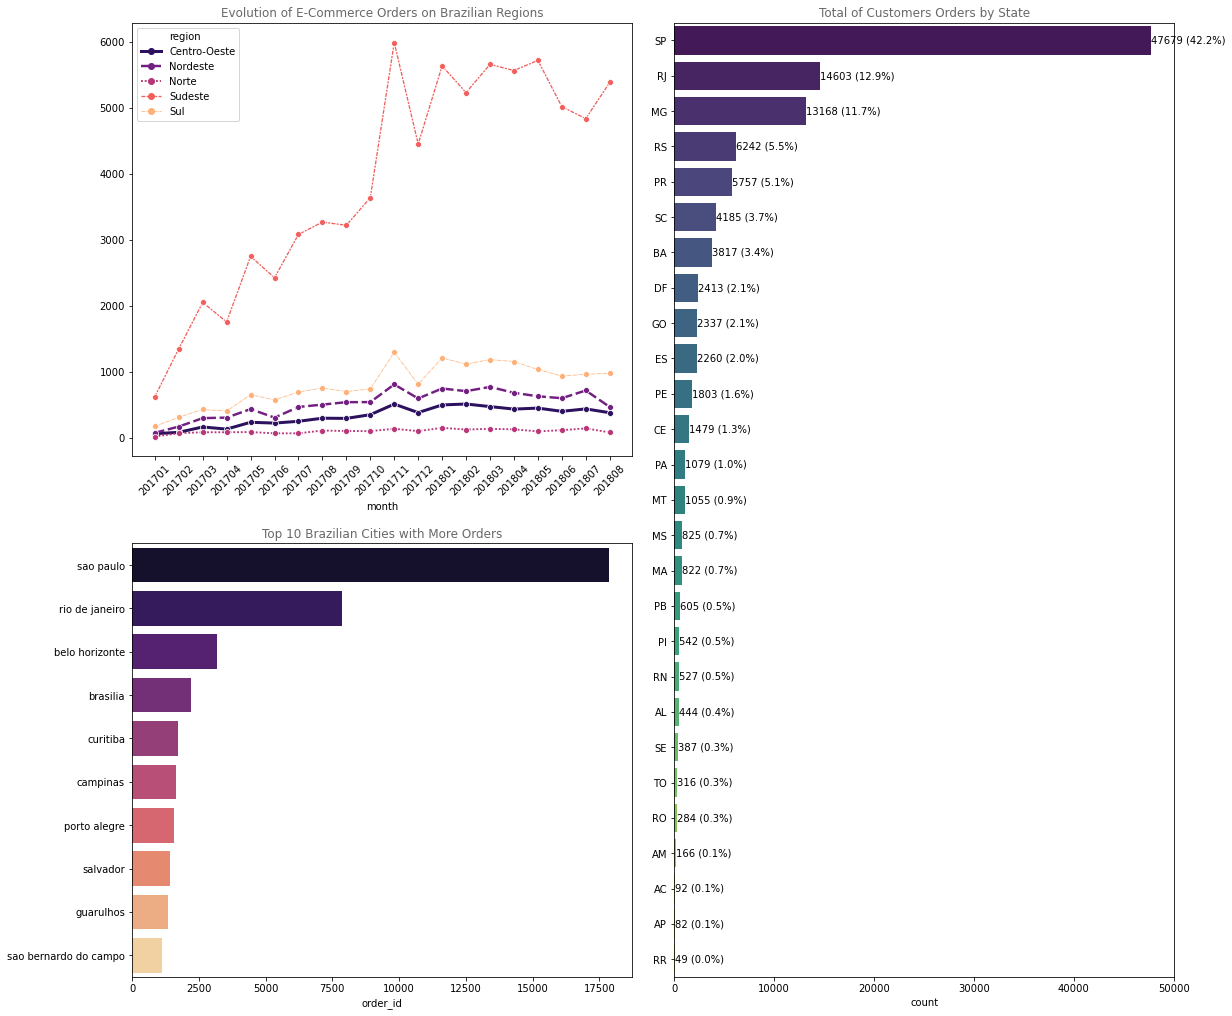

In [14]:
#Initialize figure
fig = plt.figure(constrained_layout = True, figsize = (17, 14))
gs = GridSpec(2, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

#Plot count of orders by region
sns.lineplot(x = 'month', y = 'order_count', ax = ax1, data = df_regions_group, hue = 'region', 
             size = 'region', style = 'region', palette = 'magma', markers = ['o'] * 5)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size = 12, color = 'dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

#Top cities with most orders in Brazil
sns.barplot(y = 'geolocation_city', x = 'order_id', data = df_cities_group, ax = ax2, palette = 'magma')
ax2.set_title('Top 10 Brazilian Cities with More Orders', size = 12, color = 'dimgrey')
ax2.set_ylabel('')

#Total orders by state
single_countplot(y = 'customer_state', ax = ax3, df = df_orders_filt, palette = 'viridis')
ax3.set_title('Total of Customers Orders by State', size = 12, color = 'dimgrey')
ax3.set_ylabel('')

#Display plot
plt.show()

From the above graphs, it can be seen that the sudeste "south east" region has the highest evolution of client orders between 2017 and 2018 which is inline with expecations since that region in Brazil is relatively richer than the other regions. It can also be deduced that Sao Paulo and Rio de Janeiro are the top 2 brazilian cities in terms of number of users which is also inline with expecations as those 2 cities are the richest in Brazil hence more money to spend on online shopping. There seems to be a correlation between the richness of the region and the amount of online shopping done (e.g. Salvador don't order a lot of products online ~ a possible reason could be that Salvador is considered to be a very poor city in Brazil).

#### Plot map of Brazil with concentration of purchases

In [15]:
#Import packages
import folium
from folium.plugins import FastMarkerCluster

#Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

#Create map with folium
brazilMap = folium.Map(location=[-15, -50], zoom_start = 4.0)

#Add plugin: FastMarkerCluster
FastMarkerCluster(data = locations).add_to(brazilMap)

#Display map
brazilMap

### 4. Product Categories with Highest Scores

For this part, I will be working with the productsData, reviewsData and itemsData datasets in order to identify the product categories that have the highest demand in Brazil.

#### Merge the datasets and generate list of top 15 categories based on review scores

In [16]:
#Merge productsData and itemsData into one unique dataset
products_items = pd.merge(productsData, itemsData, how = 'inner', on = 'product_id')

#Merge products_items with reviewsData for final dataset
categoriesData = pd.merge(products_items, reviewsData, how = 'inner', on = 'order_id')

#Create an aggregation of categories with their respective scores (based on review scores)
avg_score_per_category = categoriesData.groupby('product_category_name', as_index = False).agg({'review_score': ['count', 'mean']})
avg_score_per_category.columns = ['product_category_name', 'count', 'mean']

#Filter to show categories with more than 50 reviews
avg_score_per_category = avg_score_per_category[avg_score_per_category['count'] > 50]
avg_score_per_category = avg_score_per_category.sort_values(by = 'mean', ascending = False)[:15]
avg_score_per_category

,product_category_name,count,mean
48,livros_interesse_geral,553,4.439421
47,livros_importados,60,4.400000
22,construcao_ferramentas_ferramentas,103,4.359223
49,livros_tecnicos,269,4.338290
50,malas_acessorios,1092,4.309524
2,alimentos_bebidas,280,4.303571
64,portateis_casa_forno_e_cafe,76,4.302632
18,cine_foto,73,4.205479
34,fashion_calcados,265,4.200000
59,papelaria,2525,4.181386


#### Plot a barplot of the top 15 categories sold online in Brazil

Text(0.5, 1.0, 'Categories Review Score')

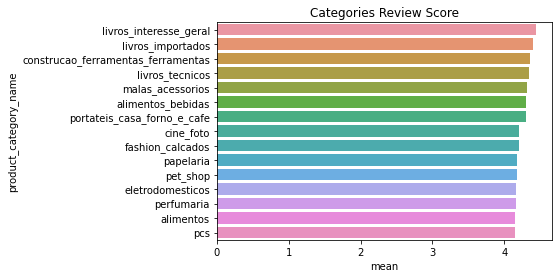

In [17]:
#Set the plot
ax = sns.barplot(x = "mean", y = "product_category_name", data = avg_score_per_category)
ax.set_title('Categories Review Score')

The products that have the highest review scores are general interest books and imported books.

### 5. Most Frequent Payment Type & Price Distribution

#### Set-up dataset and feature for plot

In [18]:
#Create dataset methodPurchase using itemsData and paymentData datasets
methodPurchase = pd.merge(itemsData, paymentData, on = 'order_id')

In [19]:
#Get the logarithmic price
methodPurchase['price_log'] = np.log(methodPurchase['price'] + 1.5)

#### Plot distributions

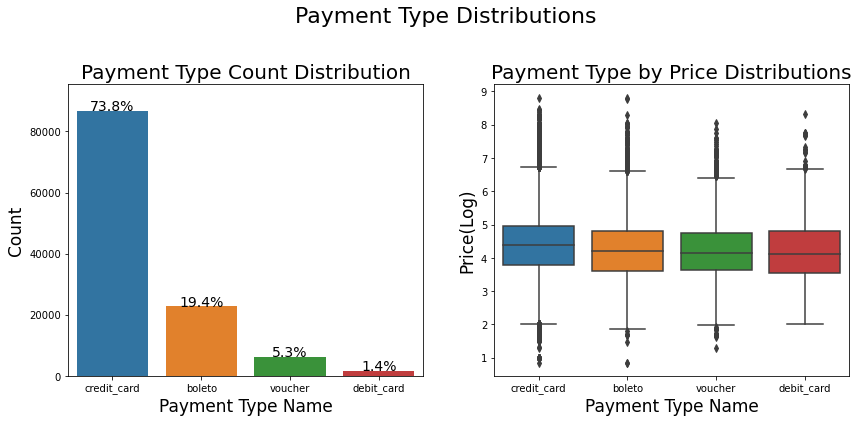

In [20]:
#Get length of dataset
total = len(methodPurchase)

#Initialize plot and set main title
plt.figure(figsize = (14,6))
plt.suptitle('Payment Type Distributions', fontsize = 22)

#Plot payment type count distribution
plt.subplot(121)
g = sns.countplot(x = 'payment_type', data = methodPurchase[methodPurchase['payment_type'] != 'not_defined'])
g.set_title("Payment Type Count Distribution", fontsize = 20)
g.set_xlabel("Payment Type Name", fontsize = 17)
g.set_ylabel("Count", fontsize = 17)

#Set plot and label format
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/total*100),
            ha = "center", fontsize = 14) 
    
g.set_ylim(0, max(sizes) * 1.1)

#Plot payment type by price distributions
plt.subplot(122)
g = sns.boxplot(x = 'payment_type', y = 'price_log',
                data = methodPurchase[methodPurchase['payment_type'] != 'not_defined'])

#Set plot labels
g.set_title("Payment Type by Price Distributions", fontsize = 20)
g.set_xlabel("Payment Type Name", fontsize = 17)
g.set_ylabel("Price(Log)", fontsize = 17)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

plt.show()

More than **73.8%** of all sales are of the payment type credit card. Second most common payment type is "boleto"(bank slip) with almost **19.4%**. The third more common payment type is voucher with **5.3%**.

### 6. Online sales growth over time

#### Group data and create dictionary with features of interest

In [21]:
#Group data to look at evolution (use df_orders_filt df created before that looks at data between 2017 and 2018 only)
df_month_aggreg = df_orders_filt.groupby(by = ['order_purchase_year', 'order_purchase_year_month'], as_index = False)

#Create dictionary
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum'
})

#### Plot the evolution of sales between 2017 and 2018

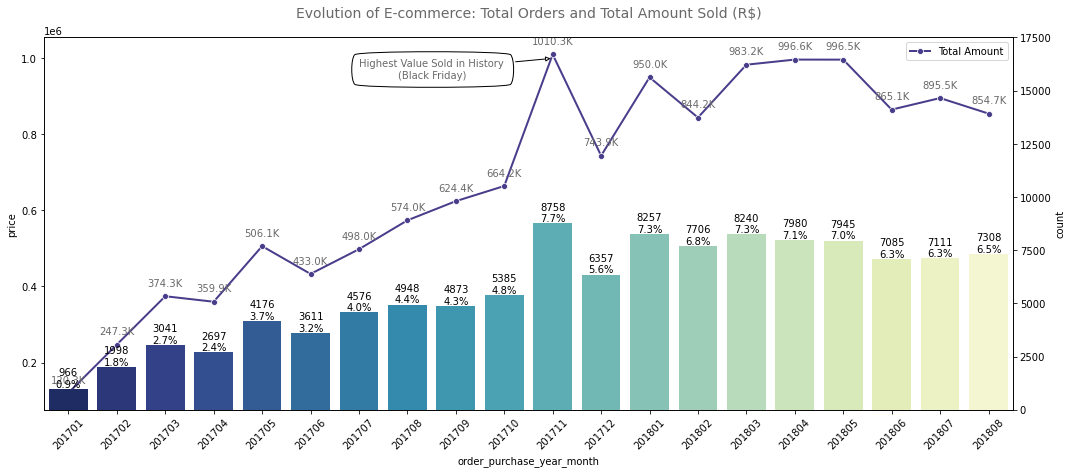

In [22]:
#Initialize the plot
fig = plt.figure(constrained_layout = True, figsize = (15, 12))

#Define axes
gs = GridSpec(2, 3, figure = fig)
ax1 = fig.add_subplot(gs[0, :])

#Plot the evolution of total orders and total sales on e-commerce
sns.lineplot(x = 'order_purchase_year_month', y = 'price', ax = ax1, data = df_month_aggreg, linewidth = 2, 
             color = 'darkslateblue', marker = 'o', label = 'Total Amount')
ax1_twx = ax1.twinx()
single_countplot(df_orders_filt, x = 'order_purchase_year_month', ax = ax1_twx, order = False, palette = 'YlGnBu_r')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

#Customize the plot
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy = (x, y), textcoords = 'offset points', xytext = (0, 10),
                ha = 'center', color = 'dimgrey')
ax1.annotate(f'Highest Value Sold in History \n(Black Friday)', (10, 1000000), xytext = (-120, -20), 
             textcoords = 'offset points', bbox = dict(boxstyle = "round4", fc = "w", pad = .8),
             arrowprops = dict(arrowstyle = '-|>', fc = 'w'), color = 'dimgrey', ha = 'center')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size = 14, color = 'dimgrey', pad = 20)

#Show plot
plt.tight_layout()
plt.show()

From the above graph, it can be seen that sales are generally growing over time which can indicate that online shopping is gaining popularity in Brazil. The peak was recorded in November 2017 (this can be related to Black Friday which usually occurs in the month of November ~ in this period usually online shopping is expected to grow exponentially as many people tend to buy in that period).

## Natural Language Processing (NLP) & Sentiment Analysis

In this section, I will be using the scores and reviews kept by customers after they have completed their purchase, to build an sentiment analysis model that can predict the sentiment of the future customers (whether positive or negative).

I will go through a series of steps such as text preprocessing, extracting features, labeling the data, building a pipeline, sentiment classification and finally the implementation to see whether the algorithm can accurately predict the sentiment of the client based on their review.

### 1. Build and understand the data

In [23]:
#Extract the score and review left by the client and drop NAs from dataset
commentsData = reviewsData.loc[:, ['review_score', 'review_english']]
commentsData = commentsData.dropna(subset = ['review_english'])
commentsData = commentsData.reset_index(drop = True)

#Get the shape of the dataset
print(f'Dataset shape: {commentsData.shape}')

#Rename the columns to 'score' and 'comment'
commentsData.columns = ['score', 'comment']
commentsData.head()

Dataset shape: (41728, 2)


,score,comment
0,5,0
1,1,0
2,5,100%
3,5,100%
4,5,100%


From the above table, it can be deduced that there are approximately **42,000** reviews that can be used for training a sentiment analysis model.

It can also be deduced that the scoring scale is from **1** to **5** (1 being the worst and 5 being the best score).

### 2. Text preprocessing

This part is the most crucial part of the analysis, as we need to make sure that we have clean text data that is free from breaklines, whitespaces, special characters, hyperlinks, non-uniform structures (uppercase and lowercase) and so on. For this, I will be using Python's regular expression package (RegEx) which is useful in text transformations.

#### Preliminary step to define function that compares text before and after changes

I will define a function that will allow me to verify the changes that I do by displaying the text before and after I apply the changes. This is good as I will make sure that the regex functions I define are working correctly.

In [24]:
def find_patterns(re_pattern, text_list):
  
    #Compile the regular expressions passed as arguments
    p = re.compile(re_pattern) #re_pattern is the regex pattern that will be used in the search
    positions_dict = {} #the index of the text of interest
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.append(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1

    return positions_dict


def print_step_result(text_list_before, text_list_after, idx_list):
  
    #Iterate over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Before: \n{text_list_before[idx]}\n')
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

#### A. Breaklines

In [25]:
#Import regex package as it will be used for all RegEx transformations
import re

def re_breakline(text_list):
    
    #Apply regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [26]:
#Create list of comment reviews
reviews = list(commentsData['comment'].values)

#Apply regex and add the column to dataset
reviews_breakline = re_breakline(reviews)
commentsData['re_breakline'] = reviews_breakline

#Verify results
print_step_result(reviews, reviews_breakline, idx_list = [5232])

--- Text 1 ---

Before: 
GOOD ORDER TRACKING.
Had trouble receiving the product

After: 
GOOD ORDER TRACKING. Had trouble receiving the product



#### B. Hyperlinks

In [27]:
def re_hyperlinks(text_list):
    
    #Apply regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [28]:
#Apply regex and add the column to dataset
reviews_hyperlinks = re_hyperlinks(reviews_breakline)
commentsData['re_hyperlinks'] = reviews_hyperlinks

#Verify results
print_step_result(reviews_breakline, reviews_hyperlinks, idx_list = [29562, 8402])

--- Text 1 ---

Before: 
I asked this: https://www.lannister.com.br/produto/22880118/botox-capilar-selafix-argan-premium-doux-clair-2x1-litro?pfm_carac=doux%20clair&pfm_index=3&pfm_page=search&pfm_pos=grid&pfm_type=search_page %

After: 
I asked this:  link  %

--- Text 2 ---

Before: 
bought the product for the color shown on the website of the American shop on the site shows http://prntscr.com/jkx7hr be black when the product arrived here come all the same color, tobacco http://prntscr.com/

After: 
bought the product for the color shown on the website of the American shop on the site shows  link  be black when the product arrived here come all the same color, tobacco  link 



#### C. Dates

In [29]:
def re_dates(text_list):
    
    #Apply regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' date ', r) for r in text_list]

In [30]:
#Apply regex and add the column to dataset
reviews_dates = re_dates(reviews_hyperlinks)
commentsData['re_dates'] = reviews_dates

#Verify results
print_step_result(reviews_hyperlinks, reviews_dates, idx_list = [65])

--- Text 1 ---

Before: 
 I look forward to delivery than bought, on 10/02/2018. So far, no product. I'm waiting for all this time, only for Joyce's service of baratheon. Await till March 27

After: 
 I look forward to delivery than bought, on  date . So far, no product. I'm waiting for all this time, only for Joyce's service of baratheon. Await till March 27



#### D. Money

In [31]:
def re_money(text_list):
    
    #Apply regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' money ', r) for r in text_list]

In [32]:
#Apply regex and add the column to dataset
reviews_money = re_money(reviews_dates)
commentsData['re_money'] = reviews_money

#Verify results
print_step_result(reviews_dates, reviews_money, idx_list = [7636])

--- Text 1 ---

Before: 
Bought 2 fixtures cod 31,971,204 worth R $ 44.90 (now $ 56.60) each and received 2 fixtures cod 32,238,771, value $ 33.90 each (now $ 37.95). I request the reimbursement of the difference or the correct product.

After: 
Bought 2 fixtures cod 31,971,204 worth R  money  (now  money ) each and received 2 fixtures cod 32,238,771, value  money  each (now  money ). I request the reimbursement of the difference or the correct product.



#### E. Numbers

In [33]:
def re_numbers(text_list):

    #Apply regex
    return [re.sub('[0-9]+', ' number ', r) for r in text_list]

In [34]:
#Apply regex and add the column to dataset
reviews_numbers = re_numbers(reviews_money)
commentsData['re_numbers'] = reviews_numbers

#Verify results
print_step_result(reviews_money, reviews_numbers, idx_list = [68, 3563])

--- Text 1 ---

Before: 
 I not used it yet, but I give it 3 stars because they did not come the screws.

After: 
 I not used it yet, but I give it  number  stars because they did not come the screws.

--- Text 2 ---

Before: 
Contrary to what was announced, automotive carpets game NOT fit properly in the Citroen Aircross 2018, especially the driver. Even cutting off parts of it was NOT cool.

After: 
Contrary to what was announced, automotive carpets game NOT fit properly in the Citroen Aircross  number , especially the driver. Even cutting off parts of it was NOT cool.



#### F. Special characters

In [35]:
def re_special_chars(text_list):
    
    #Apply regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [36]:
#Apply regex and add the column to dataset
reviews_special_chars = re_special_chars(reviews_numbers)
commentsData['re_special_chars'] = reviews_special_chars

#Verify results
print_step_result(reviews_money, reviews_special_chars, idx_list = [267, 268])

--- Text 1 ---

Before: 
👍👍👍👍👍👍👍👍👏👏👏👏👏👏👏👏

After: 
                

--- Text 2 ---

Before: 
👎

After: 
 



#### G. Whitespaces

In [37]:
def re_whitespaces(text_list):
    
    #Apply regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [38]:
#Apply regex and add the column to dataset
reviews_whitespaces = re_whitespaces(reviews_special_chars)
commentsData['re_whitespaces'] = reviews_whitespaces

#Verify results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list = [3342, 3345])

--- Text 1 ---

Before: 
I loved the product  super fast delivery 

After: 
I loved the product super fast delivery

--- Text 2 ---

Before: 
Loved the product  it was beautiful in the room of my  number  year old daughter  she s in love with niches  Arrived well before the deadline     Congratulations rapidez Produto of great quality  Super recommend 

After: 
Loved the product it was beautiful in the room of my number year old daughter she s in love with niches Arrived well before the deadline Congratulations rapidez Produto of great quality Super recommend



#### H. Stopwords

I will remove stopwords as it will help in improving the performance of the sentiment analysis model as there are fewer and only meaningful tokens left. Thus, it will increase the overall classification accuracy.

In [39]:
#Import stopwords package from NLTK
from nltk.corpus import stopwords

#Define function to remove the stopwords and to make the comments in lowercase
def stopwords_removal(text, cached_stopwords = stopwords.words('english')):
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords] #cached_ are the stopwords to use

In [40]:
#Remove stopwords and add column to dataset
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
commentsData['stopwords_removed'] = reviews_stopwords

#Verify results
print_step_result(reviews_whitespaces, reviews_stopwords, idx_list = [43, 45])

--- Text 1 ---

Before: 
 I bought a product that is defective and can not change the error on the site

After: 
bought product defective change error site

--- Text 2 ---

Before: 
 I love shopping at the American lannister store because service is good and things are always good never had a problem with the American store

After: 
love shopping american lannister store service good things always good never problem american store



#### I. Lemmatization

I will be apply text lemmatization (WordNetLemmatizer) in order strip off prefixes and suffixes that have been added to a word's base form so that I have a clean text free from word variations.

I chose lemmatization over stemming because using lemmatization will often leave a meaningful word after trimming the characters. The drawback of lemmatization is the computing speed (it is a heavier process than stemming).

(e.g: **Stemming:** activities --> activiti ||
**Lemmatization:** activities --> activity)

In [41]:
#Import necessary packages
from nltk.stem.wordnet import WordNetLemmatizer

#Define function that trims word to original form
def word_lemmatizer(text, lemmatizer = WordNetLemmatizer()):
    
    return [lemmatizer.lemmatize(c, 'v') for c in text.split()] # 'v' is for verb lemmatization

In [42]:
#Apply lemmatization and add column to dataset
reviews_lemmatizer = [' '.join(word_lemmatizer(review)) for review in reviews_stopwords]
commentsData['lemmatized'] = reviews_lemmatizer

#Verify results
print_step_result(reviews_stopwords, reviews_lemmatizer, idx_list = [45, 3234])

--- Text 1 ---

Before: 
love shopping american lannister store service good things always good never problem american store

After: 
love shop american lannister store service good things always good never problem american store

--- Text 2 ---

Before: 
loved scissors precise cutting recommend anyone wants quality scissors fast delivery

After: 
love scissor precise cut recommend anyone want quality scissor fast delivery



#### J. Create new dataset

In [43]:
#Get old shape of dataset
print('The old dataset has the following shape: ', commentsData.shape)

#Drop all rows that contain the word 'number' as it is abundant
commentsData_new = commentsData[~commentsData.lemmatized.str.contains("number")]

#Get new shape of dataset
print('The new dataset has the following shape: ', commentsData_new.shape)

The old dataset has the following shape:  (41728, 11)
The new dataset has the following shape:  (37919, 11)


### 3. Feature Extraction

In this section, I will be using count vectorizer and TF-IDF to convert text into a matrix (or vector) of features since machine learning algorithms cannot work on the raw text directly. The text needs to be quantified first.

#### Preliminary step to create a function that dummy encodes all the text (string) variables

Before performing feature extractions, I will define a function that receives a text and a vectorizer object and applies the feature extraction on the respective text data.

In [44]:
def extract_features_from_corpus(corpus, vectorizer, df = False):
    
    #Extract features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names()
    
    #Transform into a dataframe
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns = features_names)
    
    return corpus_features, df_corpus_features

#### A. CountVectorizer

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. I will be using this feature extraction technique in order to codify my text data.

In [45]:
#Import countvectorizer package
from sklearn.feature_extraction.text import CountVectorizer

#Define and store english stopwords in 'en_stopwords'
en_stopwords = stopwords.words('english')

#Create object for the CountVectorizer class
count_vectorizer = CountVectorizer(max_features = 500, min_df = 7, max_df = 0.8, stop_words = en_stopwords)

#Extract features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(commentsData_new['lemmatized'],
                                                                   count_vectorizer, df = True)

#Get shape of dataframe
print(f'Shape of countv_features matrix: {countv_features.shape}\n')

#Get snapshot of data
df_countv_features.head()

Shape of countv_features matrix: (37919, 500)



,absurd,accord,actually,ad,addition,address,advertise,afternoon,agility,agree,...,wonder,wonderful,work,worth,would,wrap,wrong,years,yes,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### B. TF-IDF

The countvectorizer method will not give me the importance of the word in the text data. Therefore, I will also use the TF-IDF, short for term frequency–inverse document frequency, to reflect on how important a word is to a document in a collection or corpus. The TF–IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [46]:
#Import TF-IDF package
from sklearn.feature_extraction.text import TfidfVectorizer

#Create an object for the TF-IDF class
tfidf_vectorizer = TfidfVectorizer(max_features = 500, min_df = 7, max_df = 0.8, stop_words = en_stopwords)

#Extracting and add features into the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(commentsData_new['lemmatized'],
                                                                 tfidf_vectorizer, df = True)

#Get shape of dataframe
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')

#Get snapshot of data
df_tfidf_features.head()

Shape of tfidf_features matrix: (37919, 500)



,absurd,accord,actually,ad,addition,address,advertise,afternoon,agility,agree,...,wonder,wonderful,work,worth,would,wrap,wrong,years,yes,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.381343,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. Labeling Data

For training a sentiment analysis model, I will need to label my main sentiments (positive and negative) in order to apply a supervised machine learning algorithm since my dataset doesn't already contain this labeling.

To do so, I will be using the scores (1 --> 5) left by the customer in order to categorize their comment as positive or negative.

#### Get the frequency of each score in the dataset

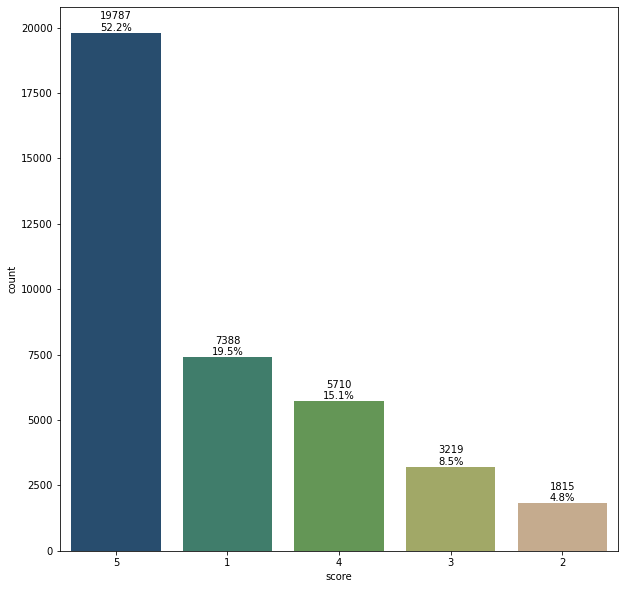

In [47]:
#Initialize plot
fig, ax = plt.subplots(figsize = (10, 10))

#Plot the countplot
single_countplot(x = 'score', df = commentsData_new, ax = ax)

#### Build scoring map and plot pie chart with frequency of sentiments

For this analysis, I will consider that the scores 4 and 5 represent a positive feedback whereas the scores 1, 2 and 3 represent negative feedback.

In [48]:
#Build a scoring map that gives each score its respective sentiment
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}

#Add the sentiment label to the dataset and map the scores created
commentsData_new['sentiment_label'] = commentsData_new['score'].map(score_map)

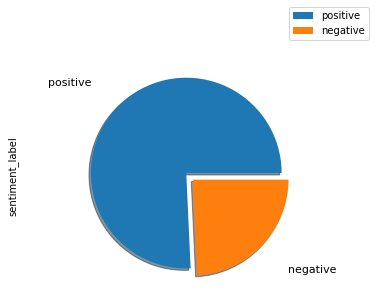

In [49]:
#Plot the pie chart
#Extract the sentiment label column
sentimentPlot = commentsData_new['sentiment_label'].value_counts(normalize = True, dropna = True)

#Set the plot characteristics
explode = (0.1, 0)
textprops = {'fontsize' : 11}

#Define the plot
sentimentPlot.plot(kind = 'pie', explode = explode, shadow = True, labeldistance = 1.37,
                  pctdistance = 1.18, textprops = textprops)

#Set the axis and display the plot
plt.axis('equal')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.05, 1.3))
plt.show()

#### Get the main n-grams presented in the corpus on positive and negative classes (unigram, bigram, trigram)

In this part, I will extract the unigram, bigram and trigrams of text data for positive and negative sentiments and see if the model works well at identify positive words from negative words. To do so, I will define a function that returns the ngams from the bag of words.

In [50]:
def ngrams_count(corpus, ngram_range, n = -1, cached_stopwords = stopwords.words('english')):
    
    #Use countvectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words = cached_stopwords, ngram_range = ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    total_list = words_freq[:n]
    
    #Return a dataframe with the ngrams count
    count_df = pd.DataFrame(total_list, columns = ['ngram', 'count'])
    return count_df

In [51]:
#Split corpus into positive and negative comments
positive_comments = commentsData_new.query('sentiment_label == "positive"')['lemmatized']
negative_comments = commentsData_new.query('sentiment_label == "negative"')['lemmatized']

#Extract the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

#Extract the top 10 bigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

#Extracting the top 10 trigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

#### Plot the top positive and negative n-grams

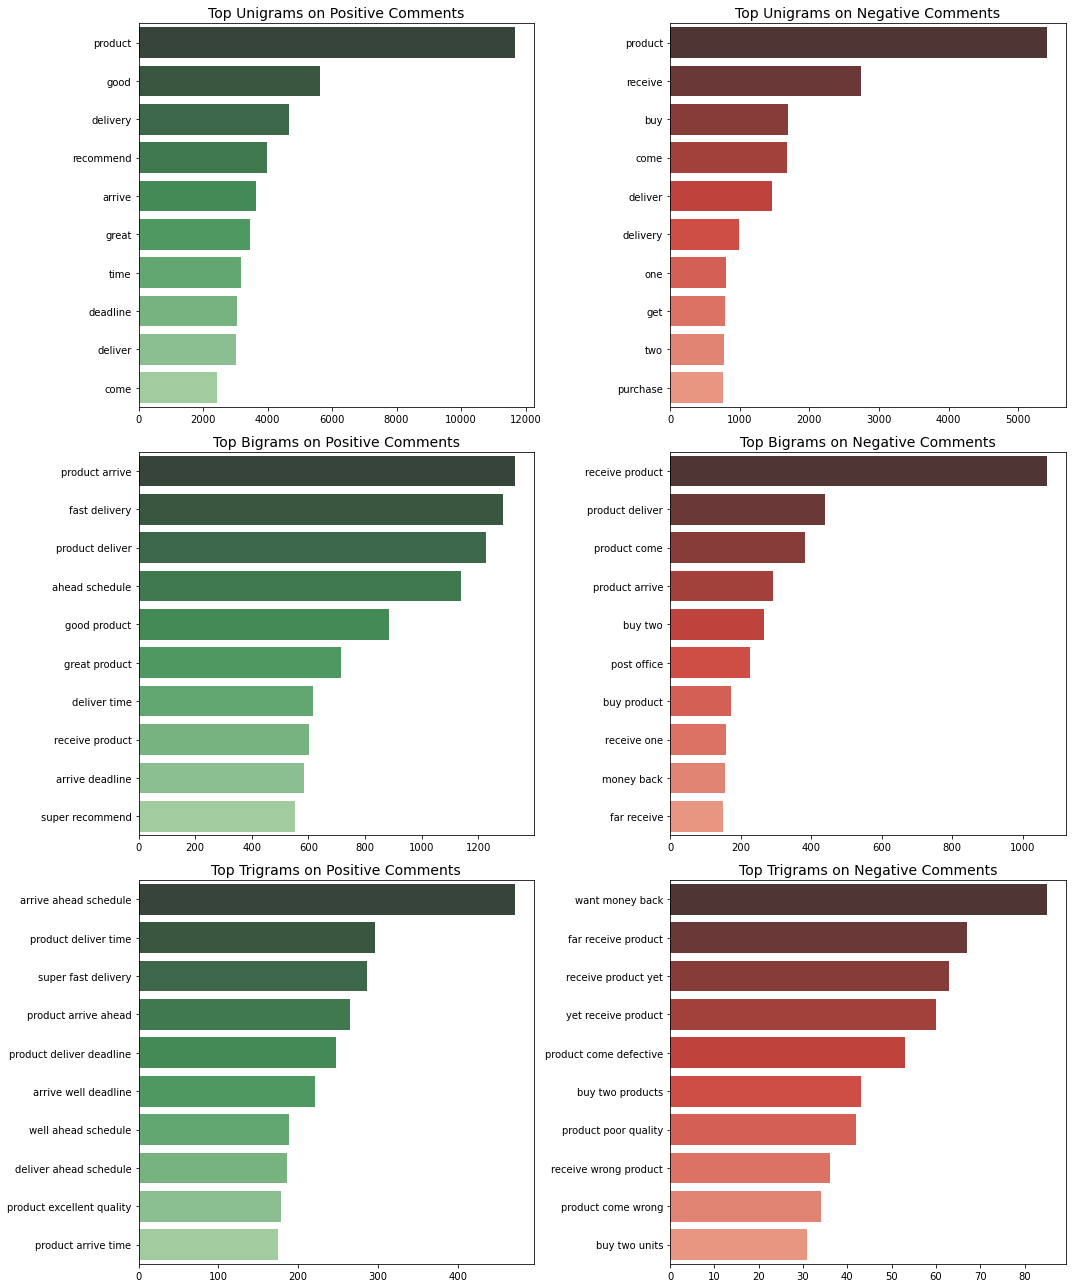

In [52]:
#Create dictionary with the n-grams created
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

#Plot the n-grams
#Initialize plot
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 18))
i, j = 0, 0
colors = ['Greens_d', 'Reds_d']

#Iterate through the data and plot
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x = 'count', y = 'ngram', data = ngram_data, ax = ax, palette = colors[j])
    
    #Customize plots
    ax.set_title(title, size = 14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    #Increment index
    j += 1
    if j == 2:
        j = 0
        i += 1

#Display plot        
plt.tight_layout()
plt.show()

Looking at the ngram plot, I can see that the positive sentiments are reflected well in all three ngrams generated with the best being in the trigram (e.g. product arrive time, product excellent quality, etc.).

Regarding the negative sentiments, it is of poor quality in the unigram but it gets better in the bigram and the best in the trigram as well (e.g product come wrong, product poor quality, product come defective, etc.)

### 5. Pipeline

In this section, I will unify all the steps that I have performed above in the text preprocessing phase and generate a unique pipeline that includes all the transformations which will be used to train the model.

#### Define classes that will be used to construct the pipeline

In [53]:
#Import package that will be used to construct the pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#Define class that will apply all regex transformations performed
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        #Apply all regex transformations performed above
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

#Define class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]


#Define class to apply the lemmatization process
class LemmatizationProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, lemmatizer):
        self.lemmatizer = lemmatizer
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return [' '.join(word_lemmatizer(comment, self.lemmatizer)) for comment in X]
    

#Define class thats extracts features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return self.vectorizer.fit_transform(X).toarray()

#### Build the pipeline

In [54]:
#Define all regex transformers that will be applied in the pipeline
regex_transformers = {
    'break_line': re_breakline,
    'hyperlinks': re_hyperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

#Define the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features = 500, min_df = 7, max_df = 0.8, stop_words = en_stopwords)

#Build the pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('english'))),
    ('lemmatized', LemmatizationProcess(WordNetLemmatizer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

#### Split the data into train/test sets for the analysis

In [55]:
#Import required package
from sklearn.model_selection import train_test_split

#Define X (inputs) and y (target)
idx_reviews = reviewsData['review_english'].dropna().index
score = reviewsData['review_score'][idx_reviews].map(score_map)

#Split train/test sets
X = list(reviewsData['review_english'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

#Apply pipeline and split the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = .33, random_state = 42)

# Verify results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 27957 - Length of one element: 500
Length of X_test_processed: 13771 - Length of one element: 500


### 6. Sentiment Classification Algorithms

In this section, I will be using all the processed text features and build a sentiment analysis model that will try to predict the sentiment of a customer based on their review.

To do so, I will be using two classification algorithms (logistic and naive bayes). I will compare them to see which model has a better predicting accuracy.

**The Naive Bayes classifier** assumes that the features are conditionally independent. Naive Bayes has a higher bias but lower variance compared to logistic regression. If the data set follows the bias then Naive Bayes will be a better classifier.

Both **Naive Bayes** and **Logistic regression** are linear classifiers, Logistic Regression makes a prediction for the probability using a direct functional form where as Naive Bayes figures out how the data was generated given the results.

#### Set the hyperparameters of interest and set up the classifier algorithms

Here, I will initialize the hyperparameters of interest for my algorithm that I will use and then once I train the data using BinaryClassifiersAnalysis, the code will run through each hyperparameter and give back the results of the combination of the best tuned hyperparameters (~ it will automatically tune the hyperparameters).

The BinaryClassifiersAnalysis function is imported from 'ml_gabriel', a notebook that contains some of useful functions for machhine learning.

In [56]:
#Import packages
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

#Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

#Set up the classifiers (I will use, as mentioned, logreg and Naive Bayes)
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

#### Train the models

I will import a python package 'ml_gabriel' which contains some machine learning functions that I have built that can help when performing comparative analyses between different classification algorithms.

In [57]:
#Import package I created that has some useful machine learning functions
from ml_gabriel import *

#Create an object and train the classifiers
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train, y_train, random_search = True, scoring = 'accuracy')

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


Training model Naive Bayes

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


#### Evaluate the model

In [58]:
#Evaluate metrics
df_performances = clf_tool.evaluate_performance(X_train, y_train, X_test, y_test, cv = 5) #5 k-folds
df_performances.reset_index(drop = True).style.background_gradient(cmap = 'Blues')

Evaluating model LogisticRegression

Evaluating model Naive Bayes



,model,approach,acc,precision,recall,f1,auc,total_time
0,LogisticRegression,Train 5 K-folds,0.872000,0.911300,0.912800,0.912000,0.931500,6.466000
1,LogisticRegression,Test,0.872600,0.912600,0.911900,0.912300,0.930100,0.073000
2,Naive Bayes,Train 5 K-folds,0.819300,0.943000,0.799800,0.865400,0.868800,7.916000
3,Naive Bayes,Test,0.823500,0.942400,0.806300,0.869000,0.871700,0.290000


The above table compares the different performance metrics of each of my 2 classifiers (the logistic regression and the naive bayes). By looking at the scores, I can see that my logistic regression algorithm performed better in all metrics except for the precision metrics where naive bayes performed better. So, just by looking at the above results, I will go ahead and use the logistic regression for my sentiment predictor.

#### Plot Confusion Matrix

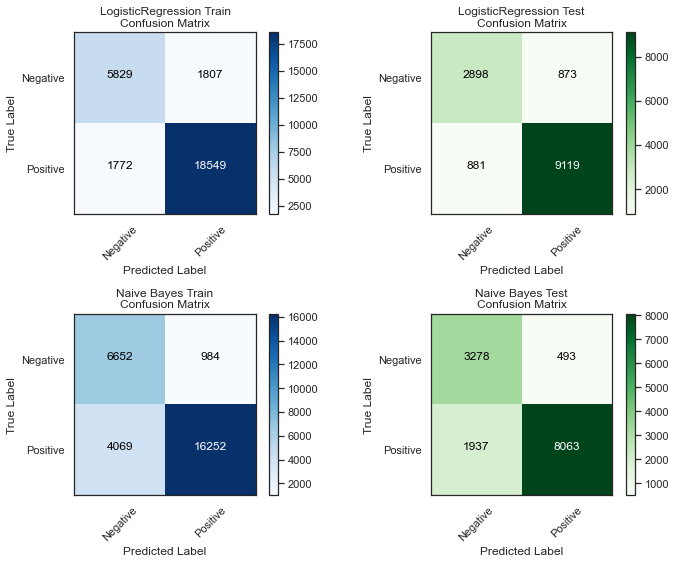

In [59]:
clf_tool.plot_confusion_matrix(classes = ['Negative', 'Positive'])

By looking at the above confusion matrix, I can deduce:

**Logistic Regression:**

- Train: The accuracy of my model is at 0.856.
- Test: The accuracy of my model is 0.852.

**Naive Bayes:**

- Train: The accuracy of my model is at 0.825.
- Test: The accuracy of my model is 0.823.

It is also worth noting that those results are subject to bias while using the accuracy measurement since there is an imbalance in the dataset as can be seen in the code below. To have a clearer and more accurate predictor, it may be better to use the ROC-AUC curve since it handles dataset imbalances well.

In [60]:
#Check if dataset balanced/imbalanced
commentsData_new.sentiment_label.value_counts()

positive    28716
negative     9203
Name: sentiment_label, dtype: int64

### 7. Implement Sentiment Predictor

#### Define function that predicts sentiment based on reviews

In [61]:
#Define a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):

    #Apply pipeline produced above
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)
    
    #Predict sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)
    
    #Plot sentiment along with score
    fig, ax = plt.subplots(figsize = (5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    
    #Edit graph appearance
    ax.text(0.5, 0.5, text, fontsize = 50, ha = 'center', color = color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha = 'center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize = 14)
    plt.show()

#### Build the model and fit the pipeline

In [62]:
#Define transformers for preparing the text input (I will use logreg since the model performed better)
model = clf_tool.classifiers_info['LogisticRegression']['estimator']

#Set the production pipeline
prod_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('english'))),
    ('lemmatized', LemmatizationProcess(WordNetLemmatizer()))
])

#Set the text vectorizer
vectorizer = text_pipeline.named_steps['text_features'].vectorizer

#### Test the predictor

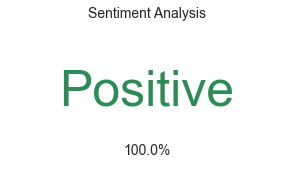

In [63]:
comment = 'I love the product'
sentiment_analysis(comment, pipeline = prod_pipeline, vectorizer = vectorizer, model = model)

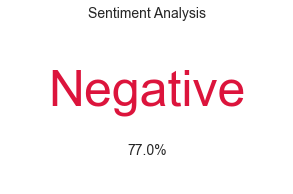

In [64]:
comment = 'The order arrived late'
sentiment_analysis(comment, pipeline = prod_pipeline, vectorizer = vectorizer, model = model)

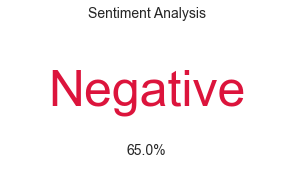

In [65]:
comment = 'Never again'
sentiment_analysis(comment, pipeline = prod_pipeline, vectorizer = vectorizer, model = model)

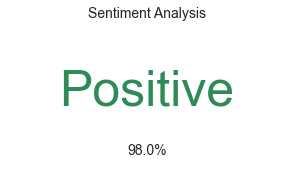

In [66]:
comment = 'Order arrived ahead of schedule'
sentiment_analysis(comment, pipeline = prod_pipeline, vectorizer = vectorizer, model = model)

### 8. WordCloud Most Frequent Words

#### Plot wordcloud with most frequent words

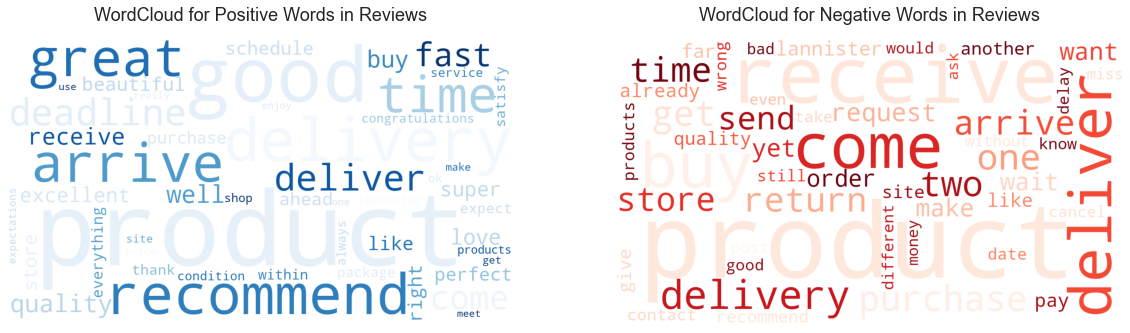

In [67]:
#Import packages
from wordcloud import WordCloud
from collections import Counter

#Generate words
pos_comments = list(commentsData_new.query('sentiment_label == "positive"')['lemmatized'].values)
positive_words = ' '.join(pos_comments).split(' ')

neg_comments = list(commentsData_new.query('sentiment_label == "negative"')['lemmatized'].values)
negative_words = ' '.join(neg_comments).split(' ')

#Use counter to create a dictionary of words
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)

#Generate wordclouds for both positive and negative comments
positive_wc = WordCloud(width = 1280, height = 720, collocations = False, random_state = 42, 
                      colormap = 'Blues', background_color = 'white',
                        max_words = 50).generate_from_frequencies(positive_dict)

negative_wc = WordCloud(width = 1280, height = 720, collocations = False, random_state = 42, 
                      colormap = 'Reds', background_color = 'white',
                        max_words = 50).generate_from_frequencies(negative_dict)


#Visualize word cloud created and the total for each sentiment
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1 = axs[0]
ax2 = axs[1]

ax1.imshow(positive_wc)
ax1.axis('off')
ax1.set_title('WordCloud for Positive Words in Reviews', size = 18, pad = 20)

ax2.imshow(negative_wc)
ax2.axis('off')
ax2.set_title('WordCloud for Negative Words in Reviews', size = 18, pad = 20)

#Show plot
plt.show()

From the above wordcloud, it can be seen that for positive words the most common texts are (great, fast, recommend and well). For the negative comments, the most common words are (time, wrong, deliver).

As mentioned earlier, when looking at unigrams, the model seems to perform better with detecting positive words and the reason behind this could be the fact that in the dataset provided, there are more positive feedback than negative feedback thus creating an imbalance in the data.

## Customer Segmentation using K-Means

For the customer segmentation, I will be focusing on the RFM (recency, frequency and monetary value) metrics  to segment the customers.

The segments that will be established are as follows:

- **Low value:** Customers who are less active than others (non-frequent buyers generate low or zero revenues).
- **Mid value:** Customers who are moderately active (fairly frequent thus generating moderate revenues).
- **High value:** Customers that are very active (frequent buyers so they have high revenues).

The group that the company should prioritze and focus on maintaining will be the 'high value' group.

### 1. Data Preparation & Cleaning

#### Create dataset for customer segmentation

In [68]:
#Create dataframe with paymentData, itemsData, ordersData and customerData
df1 = paymentData.merge(itemsData, on = 'order_id')
df2 = df1.merge(ordersData, on='order_id')

#Create the dataset
segmentationData = df2.merge(customerData, on = 'customer_id')

#Get shape of final data
print('The shape of my dataset that will be used for customer segmentation is: ', segmentationData.shape)
print('-------------------------------------------------------------------------------------')

#Display dataset
segmentationData.head()

The shape of my dataset that will be used for customer segmentation is:  (117601, 22)
-------------------------------------------------------------------------------------


,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,...,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,...,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,...,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,...,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,87695ed086ebd36f20404c82d20fca87,36060,juiz de fora,MG
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,...,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,4291db0da71914754618cd789aebcd56,18570,conchas,SP


#### Adjust data type for date columns to datetime

In [69]:
#Change the data type in the date column to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date'] 

#Iterate through date columns and change types
for col in date_columns:
    segmentationData[col] = pd.to_datetime(segmentationData[col], format = '%Y-%m-%d %H:%M:%S')

#### Handle null variables

In [70]:
#Check null values in dataset
segmentationData.isnull().mean().round(2)

order_id                         0.00
payment_sequential               0.00
payment_type                     0.00
payment_installments             0.00
payment_value                    0.00
order_item_id                    0.00
product_id                       0.00
seller_id                        0.00
shipping_limit_date              0.00
price                            0.00
freight_value                    0.00
customer_id                      0.00
order_status                     0.00
order_purchase_timestamp         0.00
order_approved_at                0.00
order_delivered_carrier_date     0.01
order_delivered_customer_date    0.02
order_estimated_delivery_date    0.00
customer_unique_id               0.00
customer_zip_code_prefix         0.00
customer_city                    0.00
customer_state                   0.00
dtype: float64

In [71]:
#Drop all nulls from dataset
segmentationData.dropna(inplace = True)

#Check if all nulls removed
segmentationData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115018 entries, 0 to 117600
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115018 non-null  object        
 1   payment_sequential             115018 non-null  int64         
 2   payment_type                   115018 non-null  object        
 3   payment_installments           115018 non-null  int64         
 4   payment_value                  115018 non-null  float64       
 5   order_item_id                  115018 non-null  int64         
 6   product_id                     115018 non-null  object        
 7   seller_id                      115018 non-null  object        
 8   shipping_limit_date            115018 non-null  datetime64[ns]
 9   price                          115018 non-null  float64       
 10  freight_value                  115018 non-null  float64       
 11  

### 2. Creating the RFM dataset

In this section, I will build my new RFM dataset containing information about all the customers (their frequency, recency and monetary value). I will also work on creating 3 groups of customers based on those scores (high value, mid value and low value).

#### Check the first and last day of purchases

In [72]:
#View the first and last date of purchase
print('Min : {}, Max : {}'.format(min(segmentationData.order_purchase_timestamp),
                                  max(segmentationData.order_purchase_timestamp)))

Min : 2016-10-03 09:44:50, Max : 2018-08-29 15:00:37


#### Creating the initial RFM dataframe

In [73]:
#Import package
import datetime as dt

#Calculate RFM
pin_date = max(segmentationData.order_purchase_timestamp) + dt.timedelta(1)

#Create the RFM dataframe
rfm = segmentationData.groupby('customer_unique_id').agg({
    'order_purchase_timestamp' : lambda x: (pin_date - x.max()).days,
    'order_item_id' : 'count', 
    'payment_value' : 'sum'})

#Rename columns
rfm.rename(columns = {'order_purchase_timestamp' : 'recency', 
                      'order_item_id' : 'frequency', 
                      'payment_value' : 'monetary'}, inplace = True)

#Display initial RFM dataframe
rfm.head()

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
0000f46a3911fa3c0805444483337064,537,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
0004aac84e0df4da2b147fca70cf8255,288,1,196.89


#### Detecting and dealing with outliers in the RFM dataset

In order to detect the outliers in my RFM dataset, I will use the IQR (inter-quartile range method) to get the boundaries of my data and identify the outliers.

In [74]:
#Define function that will computer the IQR
def limit(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    #Determine the upper and lower limits and the extreme upper and lower limits
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.5) + (IQR * 3)
    
    #Print out the exact upper and lower limits
    print('Lower Limit:', lower_limit)
    print('Lower Limit Extreme:', lower_limit_extreme)
    print('Upper Limit:', upper_limit)
    print('Upper Limit Extreme:', upper_limit_extreme)


#Define function that computes the percent outliers in the data    
def percent_outliers(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    #Determine the upper and lower limits and the extreme upper and lower limits
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.95) + (IQR * 3)
    
    #Display the percentage of outliers
    print('Lower Limit: {} %'.format(rfm[(rfm[i] >= lower_limit)].shape[0]/ rfm.shape[0]*100))
    print('Lower Limit Extereme: {} %'.format(rfm[(rfm[i] >= lower_limit_extreme)].shape[0]/rfm.shape[0]*100))
    print('Upper Limit: {} %'.format(rfm[(rfm[i] >= upper_limit)].shape[0]/ rfm.shape[0]*100))
    print('Upper Limit Extereme: {} %'.format(rfm[(rfm[i] >= upper_limit_extreme)].shape[0]/rfm.shape[0]*100))

##### A. Recency

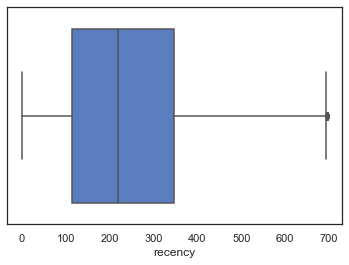

In [75]:
#Check outliers in recency feature
sns.boxplot(x = rfm["recency"])

The recency feature has no outliers.

##### B. Frequency

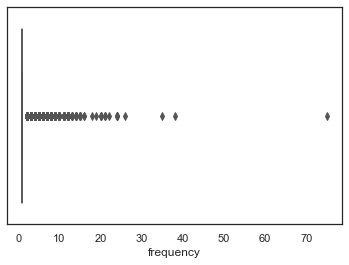

In [76]:
#Check outliers in frequency feature
sns.boxplot(x = rfm["frequency"])

The frequency feature has outliers but I will not remove those outliers since those customers probably have made a lot of transactions.

##### C. Monetary

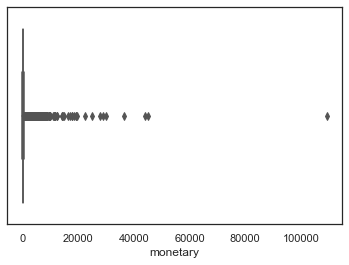

In [77]:
#Check outliers in monetary feature
sns.boxplot(x = rfm["monetary"])

The monetary feature displays outliers so I will remove them from my dataset.

In [78]:
#Display the exact lower and upper limits and extreme limits for the monetary feature along with the percentages
print(limit('monetary'))
print('-'*50)
print(percent_outliers('monetary'))

Lower Limit: -705.915
Lower Limit Extreme: -1524.78
Upper Limit: 1477.725
Upper Limit Extreme: 1750.68
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 1.2556111462272743 %
Upper Limit Extereme: 0.5335276030897461 %
None


In [79]:
#Remove outliers from monetary feature that are more than 1477 (outside the 95% max limit of the data distribution)
outliers1_drop = rfm[(rfm['monetary'] > 1477)].index
rfm.drop(outliers1_drop, inplace = True)

#### Compute the RFM percentiles and calculate the RFM score that will be used for customer labeling

In this part, I will create different customer groups based on recency, frequency and monetary metrics. I will also label the groups as high value, mid value and low value.

In [80]:
#Compute the recency score (the fewer days the better ~~ more recent)
r_labels = range(3, 0, -1)
r_groups = pd.qcut(rfm.recency, q = 3, labels = r_labels).astype('int')

#Compute frequency score
f_groups = pd.qcut(rfm.frequency.rank(method = 'first'), 3).astype('str')

#Compute monetary score
m_labels = range(1, 4)
m_groups = pd.qcut(rfm.monetary, q = 3, labels = m_labels).astype('int')

In [81]:
#Create a column for each of the scores created
rfm['r'] = r_groups.values
rfm['f'] = f_groups.values
rfm['m'] = m_groups.values

In [82]:
#Display the frequency feature in order to normalize the score for frequency
rfm['f'].value_counts()

(0.999, 30723.667]        30723
(30723.667, 61446.333]    30723
(61446.333, 92169.0]      30723
Name: f, dtype: int64

In [83]:
#Change the input in feature 'f' to 1,2,3
rfm['f'] = rfm['f'].replace({'(0.999, 30723.667]' : 1,
                             '(30723.667, 61446.333]' : 2,
                             '(61446.333, 92169.0]' : 3}).astype('int')

In [84]:
#Create an RFM segment and RFM score based on created scores in columns 'r', 'f' and 'm'
rfm['rfm_score'] = rfm[['r', 'f', 'm']].sum(axis = 1)

#Display dataset
rfm.head()

,recency,frequency,monetary,r,f,m,rfm_score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,6
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,5
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,4
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,3
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,6


#### Label customers based on the rfm score

In [85]:
#Create labels based on rfm_score
score_labels = ['Low', 'Mid', 'High']
score_groups = pd.qcut(rfm.rfm_score, q = 3, labels = score_labels)

rfm['rfm_label'] = score_groups.values
rfm.head()

,recency,frequency,monetary,r,f,m,rfm_score,rfm_label
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,6,Mid
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,5,Low
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,4,Low
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,3,Low
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,6,Mid


#### Handling data skewness and standardizing dataset

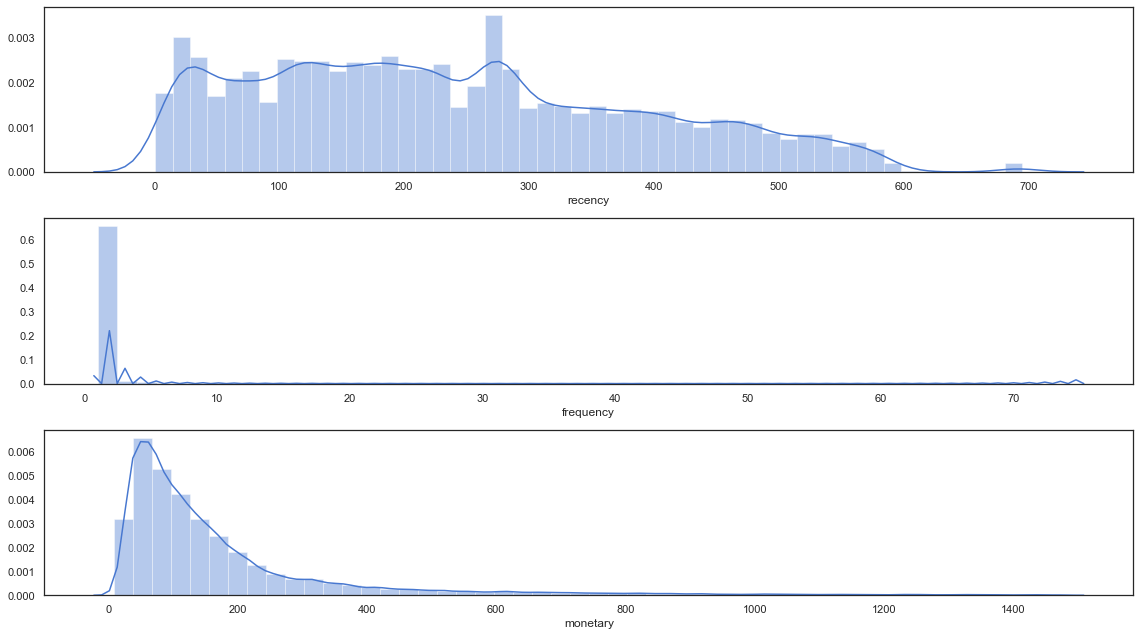

In [86]:
#Visualize the RFM values distribution
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm.recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm['frequency'], kde_kws = {'bw': 0.1}, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.monetary, label = 'Monetary')

#Display distribution
plt.tight_layout()
plt.show()

In [87]:
#Import stats package
from scipy import stats

#Normalize the distribution
rfm_log = rfm[['recency', 'monetary']].apply(np.log, axis = 1).round(3)
rfm_log['frequency'] = stats.boxcox(rfm['frequency'])[0]
rfm_log.head()

,recency,monetary,frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.718,4.955,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.745,3.303,0.0
0000f46a3911fa3c0805444483337064,6.286,4.457,0.0
0000f6ccb0745a6a4b88665a16c9f078,5.771,3.776,0.0
0004aac84e0df4da2b147fca70cf8255,5.663,5.283,0.0


In [88]:
#Import packages for standardization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Scale data (Standardize)
scaler = StandardScaler()
minmax = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [89]:
#Create a new dataframe after scaling
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,recency,monetary,frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.459832,0.227204,-0.408248
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.431444,-1.713407,-0.408248
0000f46a3911fa3c0805444483337064,1.188783,-0.357799,-0.408248
0000f6ccb0745a6a4b88665a16c9f078,0.647305,-1.157772,-0.408248
0004aac84e0df4da2b147fca70cf8255,0.533753,0.612507,-0.408248


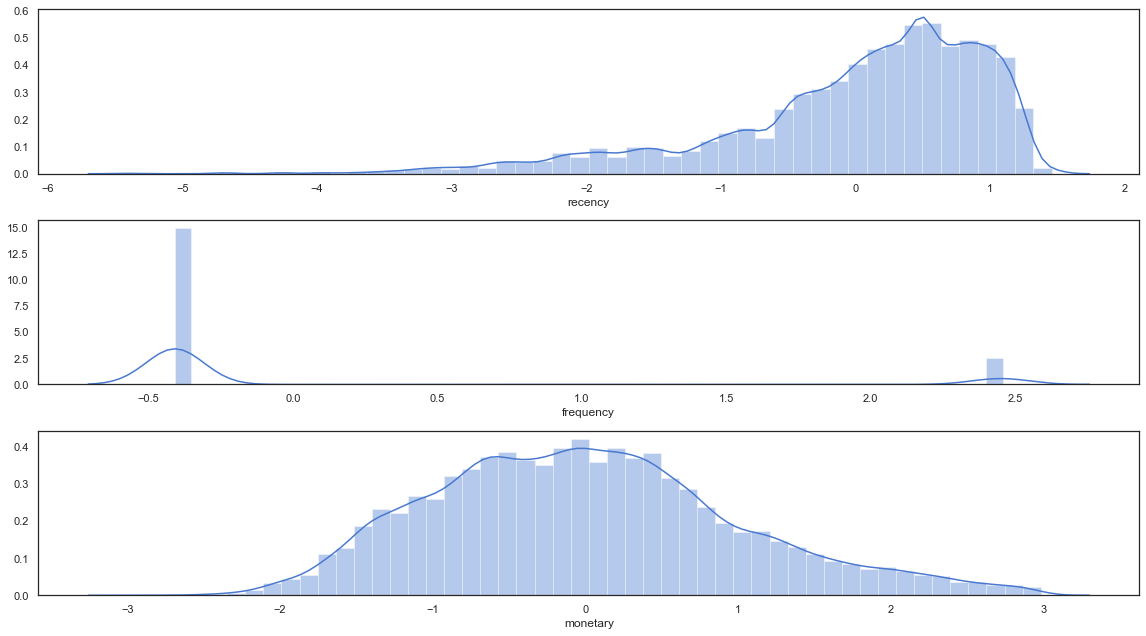

In [90]:
#Visualize RFM again after log transform and scaling
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.frequency, kde_kws = {'bw': 0.1}, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

### 3. Build and Evaluate the K-means model

I will use the K-means clustering algorithm to cluster the customers into different segments based on the RFM data geenrated.

#### Find optimal number of clusters using elbow method

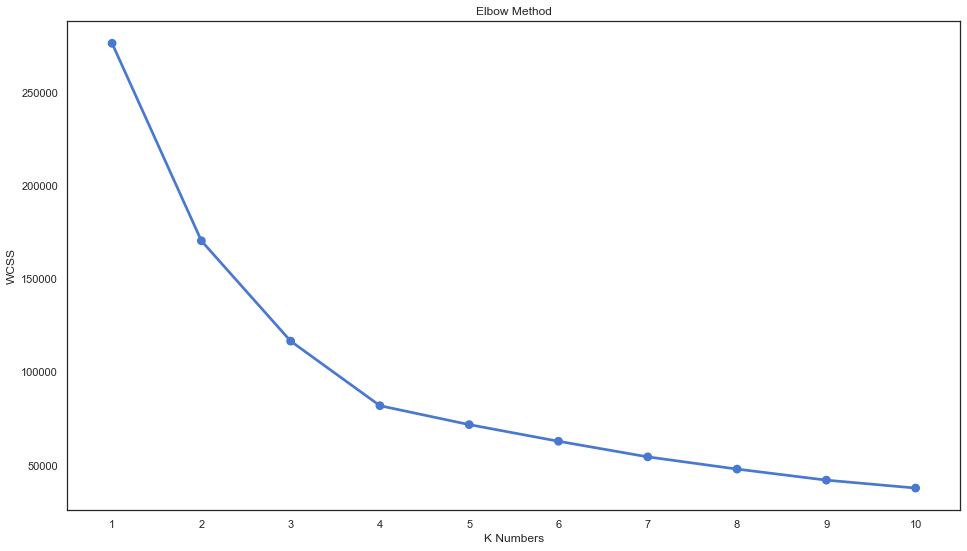

In [91]:
#Import KMeans
from sklearn.cluster import KMeans

#Define within cluster sum of squares
wcss = {}

#Iterate and get wcss
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_
    
#Plot elbow method
fig, ax = plt.subplots(figsize=(16, 9))
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

From the above elbow plot, I can deduce that the optimal number of clusters to use is 3 since after that point there is a sharp shift in the steepness of the slope.

#### Build the model

In [92]:
#Import package
from sklearn.cluster import KMeans

#Choose n_clusters = 3 according to the elbow method
kmeans_model = KMeans(n_clusters = 3, n_init = 10, init = 'k-means++', max_iter = 300)

#Fit the scaled model
kmeans_model.fit(rfm_scaled)

KMeans(n_clusters=3)

In [93]:
#Add cluster results to initial rfm dataset
rfm['k_cluster'] = kmeans_model.labels_

#Display rfm dataset
rfm.head()

,recency,frequency,monetary,r,f,m,rfm_score,rfm_label,k_cluster
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,6,Mid,2
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,5,Low,2
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,4,Low,2
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,3,Low,2
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,6,Mid,2


#### Evaluate the K-means model

After creating the k-means model, I will evaluate whether the clusters are really different from each other (unique) using the silhouette analysis plot. The closer the score to 1 implies that the difference between the clusters are more visible. If the score is close to 0, it implies that clusters are somehow similar to each other (not what we look for). If the score is closer to -1, that means that the clustering is completely wrong.

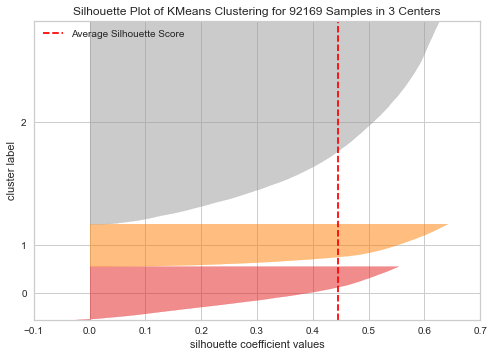

In [94]:
#Import silhouette visualizer
from yellowbrick.cluster import SilhouetteVisualizer

#Plot
visualizer = SilhouetteVisualizer(kmeans_model)
visualizer.fit(rfm_scaled) 
visualizer.poof() 

Looking at the score, we see that it is around 0.45 which means that the clustering is adequate but not optimal. Also the thickness of each silhouette can give an idea on the size of each cluster.

#### Plot Snake Plot

I will use a snake plot to make it easier to see the clusters that were created with the K-means algorithm. The snake plot is a technique that falls under the umbrella term of "perceptual mapping." The concept of a snake plot is as follows: First gather the benefits that customers use to judge the different products on the market.

In [95]:
#Put everything in the scaled data
rfm_scaled['k_cluster'] = kmeans_model.labels_
rfm_scaled['rfm_label'] = rfm.rfm_label
rfm_scaled.reset_index(inplace = True)

#Display scaled dataset
rfm_scaled.head()

,customer_unique_id,recency,monetary,frequency,k_cluster,rfm_label
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.459832,0.227204,-0.408248,2,Mid
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.431444,-1.713407,-0.408248,2,Low
2,0000f46a3911fa3c0805444483337064,1.188783,-0.357799,-0.408248,2,Low
3,0000f6ccb0745a6a4b88665a16c9f078,0.647305,-1.157772,-0.408248,2,Low
4,0004aac84e0df4da2b147fca70cf8255,0.533753,0.612507,-0.408248,2,Mid


In [96]:
#Melt dataframe that have been created
rfm_melted = pd.melt(frame = rfm_scaled, id_vars = ['customer_unique_id', 'rfm_label', 'k_cluster'], 
                     var_name = 'metrics', value_name = 'value')

#Display melted dataframe
rfm_melted.head()

,customer_unique_id,rfm_label,k_cluster,metrics,value
0,0000366f3b9a7992bf8c76cfdf3221e2,Mid,2,recency,-0.459832
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Low,2,recency,-0.431444
2,0000f46a3911fa3c0805444483337064,Low,2,recency,1.188783
3,0000f6ccb0745a6a4b88665a16c9f078,Low,2,recency,0.647305
4,0004aac84e0df4da2b147fca70cf8255,Mid,2,recency,0.533753


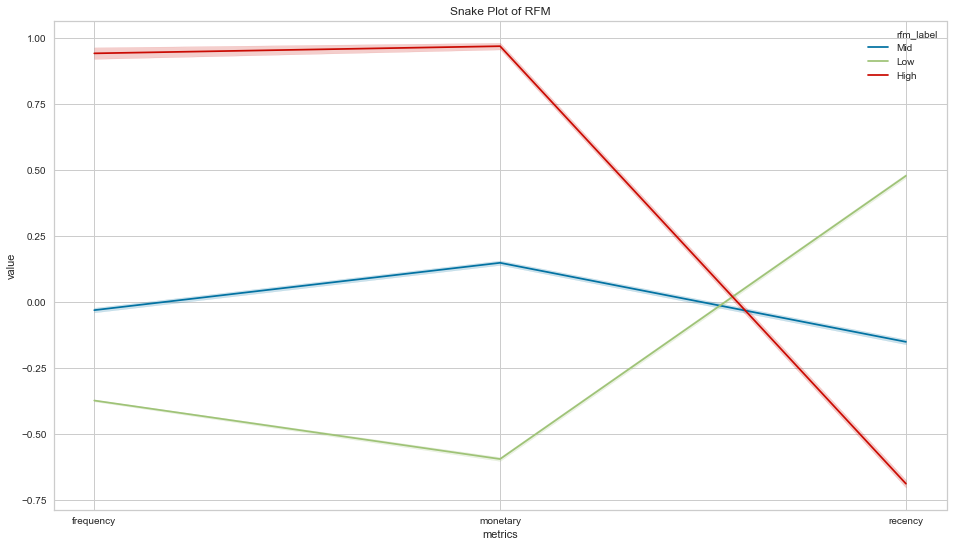

In [97]:
#Visualize snake plot
fig, ax = plt.subplots(figsize = (16, 9))
sns.lineplot(x = 'metrics', y = 'value', hue = 'rfm_label', data = rfm_melted)

#Set title and legend
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

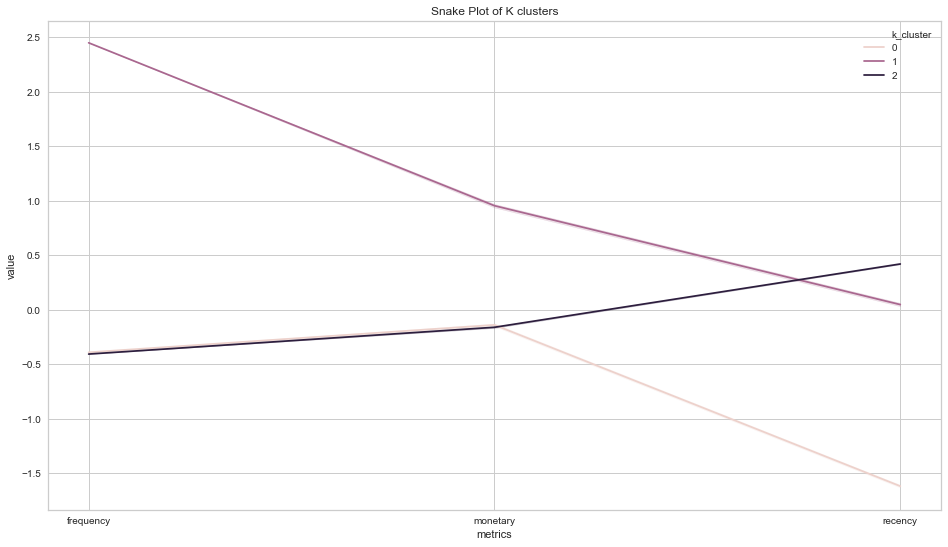

In [98]:
#Visualize the snake plot with K-Means
fig, ax = plt.subplots(figsize = (16, 9))
sns.lineplot(x = 'metrics', y = 'value', hue = 'k_cluster', data = rfm_melted)

#Set title and legend
plt.title('Snake Plot of K clusters')
plt.legend(loc = 'upper right')

Text(0, 0.5, 'Number of Customers')

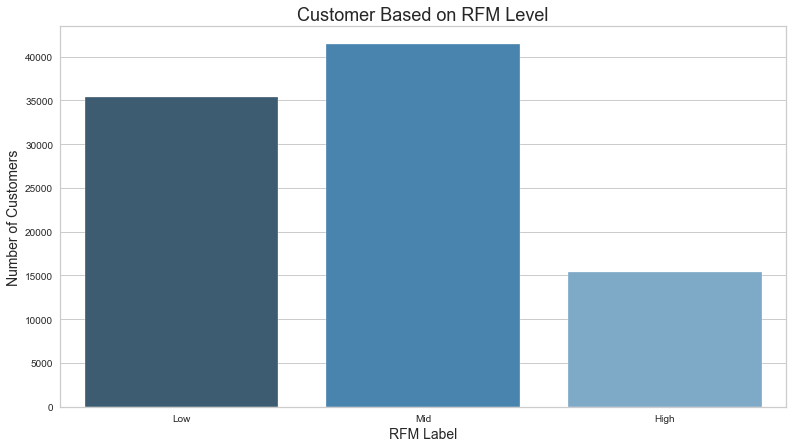

In [99]:
#Get number of customers in each category
rfm_cus_level = rfm_scaled.groupby('rfm_label')['customer_unique_id'].nunique().reset_index()

#Visualize
fig = plt.figure(figsize = (13,7))
sns.barplot(y = rfm_cus_level['customer_unique_id'], x = rfm_cus_level['rfm_label'], palette  ="Blues_d")

#Set the title and labels
plt.title('Customer Based on RFM Level',fontsize = 18)
plt.xlabel('RFM Label',fontsize = 14)
plt.ylabel('Number of Customers',fontsize = 14)

**Low-value:** The customers who had the least frequent purchases and the lowest transaction monetary value. The customers are also the most recent purchasers between the 3 categories. There are around 35,000 customers of this type.

**Mid-value:** The customers who make purchases quite often and have a monetary value that is quite high. The last transaction time was quite long though. There are around 42,000 customers of this type.

**High-value:** Customers who frequently shop and have a lot of nominal transactions, but the last transaction took the longest time between the 3 categories. There are around 15,000 customers of this type.